In [1]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import AtariPreprocessing, FrameStack

import numpy as np
import matplotlib.pyplot as plt


In [2]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        meanings = env.unwrapped.get_action_meanings()
        self.fire_action = meanings.index("FIRE") if "FIRE" in meanings else None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)

        if self.fire_action is None:
            return obs, info

        # press FIRE once
        obs, reward, terminated, truncated, info = self.env.step(self.fire_action)

        # if episode ends restart
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)

        return obs, info


In [3]:
def make_env(render_mode=None):
    def _env():
        env = gym.make("ALE/Breakout-v5", render_mode=render_mode, frameskip=1)

        env = FireResetEnv(env)

        env = AtariPreprocessing(
            env,
            grayscale_obs=True,
            frame_skip=4,
            scale_obs=False,
            terminal_on_life_loss=True
        )

        env = FrameStack(env, num_stack=4)

        return env

    return _env


In [4]:
env = DummyVecEnv([make_env()])


In [5]:
model = DQN(
    "CnnPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=100_000,
    learning_starts=10_000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,
    target_update_interval=10_000,
    exploration_fraction=0.1,
    exploration_final_eps=0.01,
    verbose=1
)


Using cpu device


c:\Users\mirza\OneDrive\Documents\FinalProject1\env\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.77GB
  warnings.warn(


In [ ]:
TIMESTEPS = 300_000
model.learn(total_timesteps=TIMESTEPS)
model.save("dqn_breakout")


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 478      |
|    time_elapsed     | 0        |
|    total_timesteps  | 86       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 509      |
|    time_elapsed     | 0        |
|    total_timesteps  | 170      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 550      |
|    time_elapsed     | 0        |
|    total_timesteps  | 314      |
----------------------------------
----------------------------------
| rollout/          

In [ ]:
test_env = DummyVecEnv([make_env("human")])

obs = test_env.reset()
done = False
total_reward = 0

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated = test_env.step(action)
    total_reward += reward[0]
    done = terminated or truncated

print("Test Episode Reward:", total_reward)
test_env.close()


Test Episode Reward: 0.0


In [ ]:
def evaluate(model, env_fn, episodes=10):
    rewards = []
    for ep in range(episodes):
        env = DummyVecEnv([env_fn()])
        obs = env.reset()
        done = False
        total = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated = env.step(action)
            total += reward[0]
            done = terminated or truncated

        env.close()
        rewards.append(total)
        print(f"Episode {ep+1}: {total}")

    print(f"\nMean reward: {np.mean(rewards):.2f}, Std: {np.std(rewards):.2f}")
    return rewards


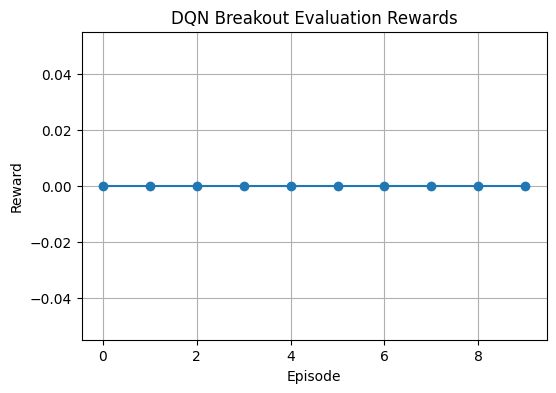

In [ ]:
scores = evaluate(model, make_env, episodes=10)


In [6]:
obs = env.reset()
print(obs.shape)
print(obs.mean(), obs.min(), obs.max())


(1, 4, 84, 84)
41.81207482993197 0 148


In [6]:
env = DummyVecEnv([make_env(None)])
obs = env.reset()

for i in range(10):
    action = env.action_space.sample()
    obs, reward, terminated, truncated = env.step([action])
    print(f"Step {i}: mean={obs.mean()}, min={obs.min()}, max={obs.max()}")


Step 0: mean=41.832589285714285, min=0, max=148
Step 1: mean=41.839958900226755, min=0, max=148
Step 2: mean=41.84410430839002, min=0, max=148
Step 3: mean=41.86465419501134, min=0, max=148
Step 4: mean=41.867842970521544, min=0, max=148
Step 5: mean=41.88421201814059, min=0, max=148
Step 6: mean=41.90054563492063, min=0, max=148
Step 7: mean=41.900403911564624, min=0, max=148
Step 8: mean=41.88414115646258, min=0, max=148
Step 9: mean=41.864477040816325, min=0, max=148
